In [38]:
%matplotlib inline
from IPython import display
import os
import io
import itertools
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import importlib

import rtmtools.lblrtm.aerutils as aerutils
import rtmtools.lblrtm.aeranalyse as aeranalyse
import rtmtools.lblrtm.visualisation as viz

import rtmtools.clirad.sw.wrangle as cliradwrangle
import rtmtools.clirad.sw.analyse as cliradanalyse
import rtmtools.clirad.lw.info

import rtmtools.rrtmg.lw.wrangle as rrtmgwrangle
import rtmtools.rrtmg.sw.analyse as rrtmganalyse



importlib.reload(aerutils)
importlib.reload(aeranalyse)
importlib.reload(viz)

importlib.reload(cliradwrangle)
importlib.reload(cliradanalyse)
importlib.reload(rtmtools.clirad.lw.info)

importlib.reload(rrtmgwrangle)
importlib.reload(rrtmganalyse)

<module 'rtmtools.rrtmg.sw.analyse' from '/nuwa_cluster/home/jackyu/radiation/rtmtools/rtmtools/rrtmg/sw/analyse.py'>

In [70]:
name_molecule = r'$H_{2}O + CO_{2}$'

#### Load CRD results

In [29]:
# Get lbl line-by-line results
pathout_crd = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H2008_H2O_CO2_cut25/OUTPUT_RADSUM'
pnl_crd = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd, cooling_rate = True, signed_fluxes = True)


In [13]:
# H1996 cutoff = 10 cm-1
pathout_crd1 = '/nuwa_cluster/home/jackyu/radiation/crd/LW/examples/lbl_H1996_CO2_cut10/OUTPUT_RADSUM'
pnl_crd1 = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_crd1, cooling_rate = True, signed_fluxes = True)


#### Load CLIRAD results

In [33]:
# Read OUTPUT_CLIRAD.dat
pathout_clirad = '/nuwa_cluster/home/jackyu/radiation/clirad/LW/examples/mls75_H2O_CO2_H2012/OUTPUT_CLIRAD.dat'
pnl_clirad = cliradwrangle.OUTPUT_CLIRAD_to_PandasPanel(readfrom = pathout_clirad, cooling_rate = True, signed_fluxes= True)


In [15]:
# prepare results Hitran 2012 updated version
def path_cliradlw_h2012():
    return '../clirad/LW/examples/mls75_CO2_H2012/CLIRAD_IR_output.dat'


def get_rateT(df, ratename = 'cooling rates'):
    return pd.DataFrame({'pressure': .5 * (df['p'].values[1:] + df['p'].values[: -1]),
                    ratename: df[ratename].values[1:]})


df = cliradwrangle.output_txtfile_to_DataFrame(path_cliradlw_h2012())

rateT_clirad2012 = get_rateT(df, ratename = 'cooling rates')

#### Load LBLRTM results

In [4]:
# Get AER line-by-line results
pathout_lblrtm = '/nuwa_cluster/home/jackyu/line_by_line/aerlbl_v12.2_package/runs/LW/run_mls70pro_H2O_CO2/OUTPUT_RADSUM'
pnl_lblrtm = aerutils.OUTPUT_RADSUM_to_pandasPanel(readfrom = pathout_lblrtm, signed_fluxes = True, cooling_rate = True)



#### Load RRTMG results

In [31]:
pathout_rrtmg = '/nuwa_cluster/home/jackyu/radiation/rrtmg/LW/examples/mls70_H2O_CO2/OUTPUT_RRTM'
pnl_rrtmg = rrtmgwrangle.OUTPUT_RRTM_to_pandasPanel(readfrom = pathout_rrtmg, signed_fluxes = True, cooling_rate = True)



# Total cooling rates

In [69]:
xlim_linear = (- 0.5, 3)

In [76]:
def plot_total_cooling_rates(infos_wavenumber = None, infos_spectralband = None):
    global molecule_name, xlim_linear
    
    levels_atm = [70, 30, 0]
    
    names, colours, linestyles, dfs = [], [], [], []
    
    if infos_wavenumber:
        names_wavenumber, colours_wavenumber, linestyles_wavenumber, pnls_wavenumber = \
        map(list, zip(*infos_wavenumber))
        dfs_wavenumber = [aeranalyse.sum_OUTPUT_RADSUM_over_wbands(pnl, V1 = 0, V2 = 3000) \
                          for pnl in pnls_wavenumber]        
        
        names.extend(names_wavenumber)
        colours.extend(colours_wavenumber)
        linestyles.extend(linestyles_wavenumber)
        dfs.extend(dfs_wavenumber)
        
        
    if infos_spectralband:
        names_spectralband, colours_spectralband, linestyles_spectralband, pnls_spectralband = \
        map(list, zip(*infos_spectralband))
        dfs_spectralband = [cliradanalyse.sum_OUTPUT_CLIRAD_over_wbands(pnl, wbands = range(1, 11))\
                            for pnl in pnls_spectralband]
        
        names.extend(names_spectralband)
        colours.extend(colours_spectralband)
        linestyles.extend(linestyles_spectralband)
        dfs.extend(dfs_spectralband)
        
    
    if infos_wavenumber or infos_spectralband:
        dfs_atm = [df.loc[levels_atm, :] for df in dfs]
        viz.tabulate_difference(dfs = dfs_atm, 
                                names = names,
                                title = 'Total cooling rate. {}'.format(name_molecule))         
 
        max_cr = max([df['cooling_rate'].max() for df in dfs])

        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Total cooling rate. {}'.format(name_molecule),
                              cooling_rate = True,
                             xlim_linear = xlim_linear, 
                              xlim_log = (- .1, 20) if max_cr >= 20 else None)
    
        display.display(plt.gcf()); plt.close()
    


Total cooling rate. $H_{2}O + CO_{2}$

LBLRTM
     pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.0024 -303.296753    0.000000 -303.296753      0.000000
30   299.8000 -314.274467   51.898980 -262.375487      2.224562
0   1013.0000 -423.532488  302.385141 -121.147347      1.316827

CRD
       pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.002417 -303.601460    0.000000 -303.601460      0.000000
30   299.800000 -314.294443   51.895706 -262.398737      2.364306
0   1013.000000 -423.662018  302.680387 -120.981632      1.334258

RRTMG
      pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -302.2284     0.0000 -302.2284       0.00000
30   299.70000 -313.3890    51.7261 -261.6629       2.18648
0   1013.00000 -423.5981   303.9900 -119.6081       1.36321

CLIRAD
       pressure     flux_up   flux_down    net_flux  cooling_rate
70     0.002417 -303.574586    0.013619 -303.560967     25.695853
30   299.800000 -314.366306   51.973508 -

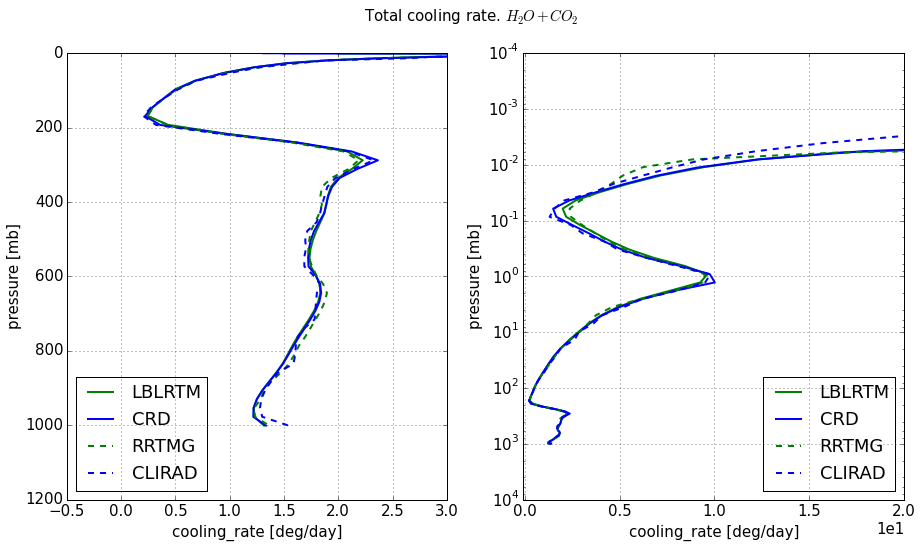

In [77]:
plot_total_cooling_rates(infos_wavenumber = [('LBLRTM', 'g', '-', pnl_lblrtm),\
                                            ('CRD', 'b', '-', pnl_crd),\
                                            ('RRTMG', 'g', '--', pnl_rrtmg)],\
                        infos_spectralband = [('CLIRAD', 'b', '--', pnl_clirad)])

In [65]:
xlim_linear = (-.5, 2)

# In RRTMG's wavenumber bands

In [78]:

def fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, *infos_lbl):
    global name_molecule, xlim_linear
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        
    lbl_pnls_by_rrtmg_bands = [aeranalyse.lines2bands(pnl_lbl, wbands = pnl_rrtmg.items.values)\
                              for pnl_lbl in pnls_lbl]
    
    names.append('RRTMG')
    colours.append('g')
    linestyles.append('--')
    pnls = [pnl_rrtmg] + lbl_pnls_by_rrtmg_bands
    
    for item in pnl_rrtmg.items:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[item].loc[atm_levels, :] for pnl in pnls]
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'RRTMG Wavenumber band: {} ~ {} cm-1'.format(*item))      

        dfs = [pnl[item] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])        
        
        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {} ~ {} cm-1'.format(name_molecule, *item),
                              cooling_rate = True,
                             xlim_linear = xlim_linear)
    
        display.display(plt.gcf()); plt.close()
    


Flux tables and cooling rates in RRTMG spectral bands


---------------------------------------------------------------------------


RRTMG Wavenumber band: 10.0 ~ 350.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -36.3061     0.0000  -36.3061      -0.00000
30   299.70000 -38.7258    22.3568  -16.3690       1.36489
0   1013.00000 -54.5825    54.5778   -0.0047       0.00201

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -36.618217   0.000000 -36.618217      0.000000
30   299.800000 -38.842137  22.076937 -16.765200      1.442737
0   1013.000000 -54.573788  54.550693  -0.023095      0.008350

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -36.723340   0.000000 -36.723340      0.000000
30   299.8000 -38.985446  22.030607 -16.954839      1.334079
0   1013.0000 -54.581667  54.656241   0.074573      0.030404

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
7

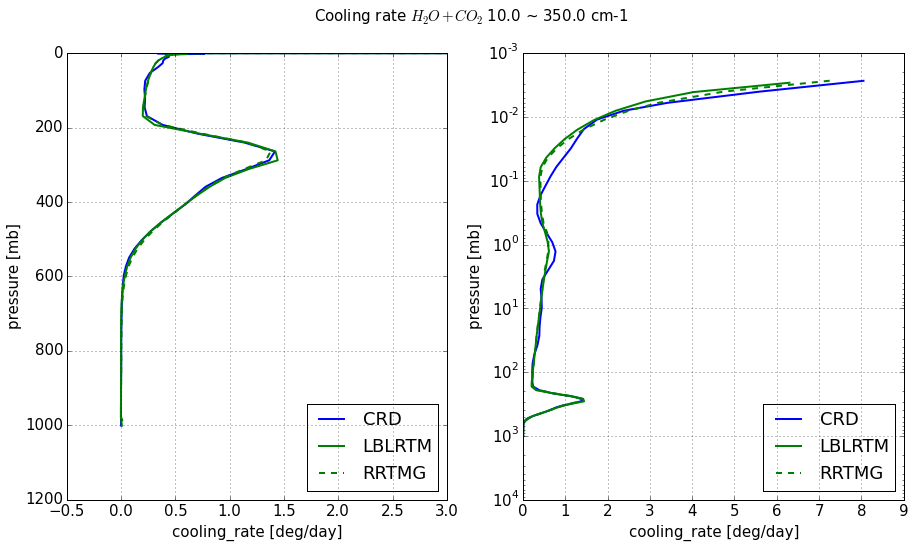

---------------------------------------------------------------------------


RRTMG Wavenumber band: 350.0 ~ 500.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -44.3208     0.0000  -44.3208      -0.00000
30   299.70000 -45.1535     5.2688  -39.8847       0.46769
0   1013.00000 -60.9174    60.7515   -0.1659       0.05173

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -44.422872   0.000000 -44.422872      0.000000
30   299.800000 -45.270432   5.428132 -39.842299      0.522787
0   1013.000000 -60.916638  60.564831  -0.351806      0.065122

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -44.312136   0.000000 -44.312136      0.000000
30   299.8000 -45.185748   5.581636 -39.604112      0.506832
0   1013.0000 -60.917465  60.568614  -0.348851      0.074174

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.102072   0.000000  0.102072     -0.00000

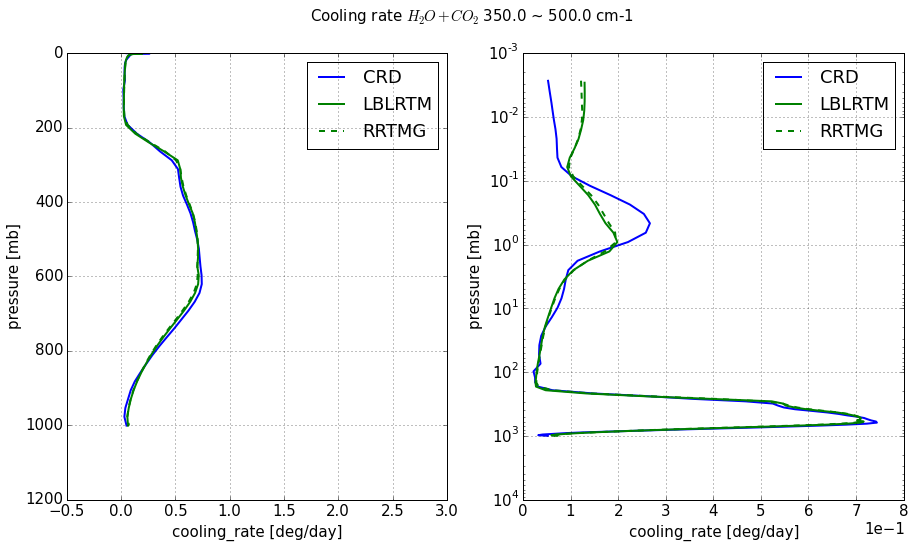

---------------------------------------------------------------------------


RRTMG Wavenumber band: 500.0 ~ 630.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -41.7902     0.0000  -41.7902      -0.00000
30   299.70000 -43.5427     4.5282  -39.0145       0.15234
0   1013.00000 -58.6463    56.8235   -1.8228       0.25085

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -41.522534   0.000000 -41.522534      0.000000
30   299.800000 -43.395879   4.771101 -38.624778      0.181807
0   1013.000000 -58.652387  56.279587  -2.372799      0.236893

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -41.392641   0.000000 -41.392641      0.000000
30   299.8000 -43.300757   4.818022 -38.482735      0.180740
0   1013.0000 -58.646623  56.311634  -2.334990      0.236564

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.267666   0.000000 -0.267666     -0.00000

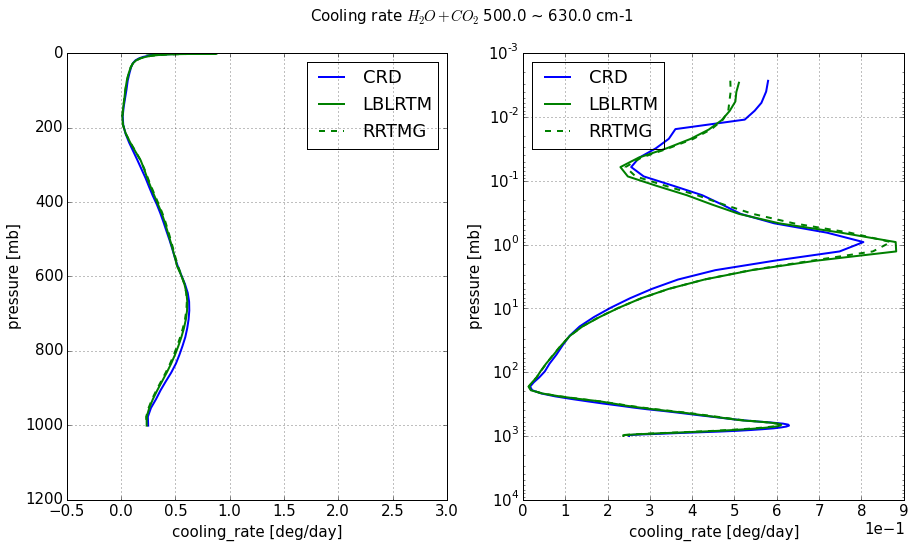

---------------------------------------------------------------------------


RRTMG Wavenumber band: 630.0 ~ 700.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -11.9265     0.0000  -11.9265      -0.00000
30   299.70000 -14.5164    13.4961   -1.0203       0.04514
0   1013.00000 -30.8951    30.8533   -0.0418       0.01642

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -12.094158   0.000000 -12.094158      0.000000
30   299.800000 -14.485330  13.465687  -1.019643      0.045106
0   1013.000000 -30.901144  30.867650  -0.033493      0.011434

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -12.024655   0.000000 -12.024655      0.000000
30   299.8000 -14.560587  13.375094  -1.185493      0.043496
0   1013.0000 -30.895458  30.837079  -0.058379      0.012640

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.167658   0.000000  0.167658     -0.00000

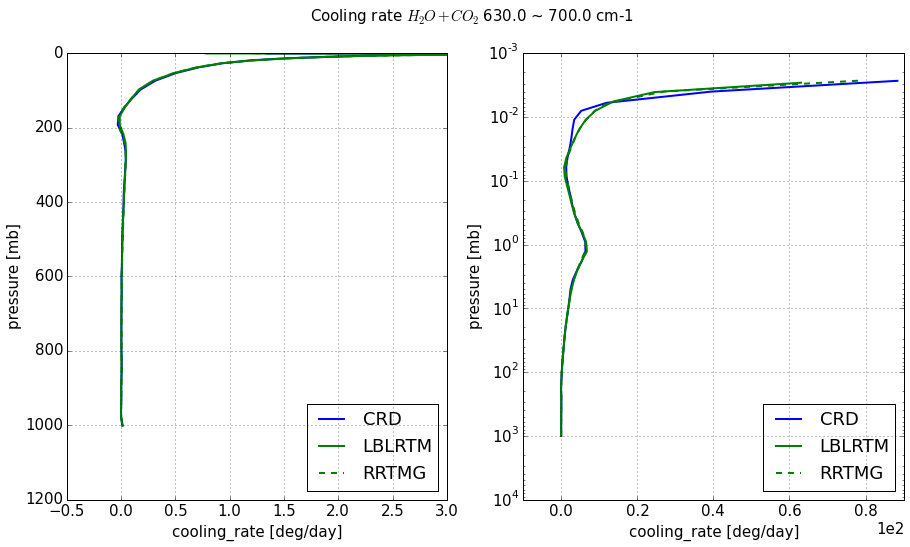

---------------------------------------------------------------------------


RRTMG Wavenumber band: 700.0 ~ 820.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -36.2693     0.0000  -36.2693      -0.00000
30   299.70000 -38.3378     3.8285  -34.5093       0.05639
0   1013.00000 -48.8867    30.5033  -18.3834       0.31034

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -36.177944   0.000000 -36.177944      0.000000
30   299.800000 -38.257873   4.058243 -34.199629      0.062771
0   1013.000000 -48.899846  30.810699 -18.089147      0.292477

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -36.339553   0.000000 -36.339553      0.000000
30   299.8000 -38.432263   3.974650 -34.457613      0.058566
0   1013.0000 -48.886744  30.485752 -18.400992      0.292447

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003 -0.091356   0.000000 -0.091356     -0.00000

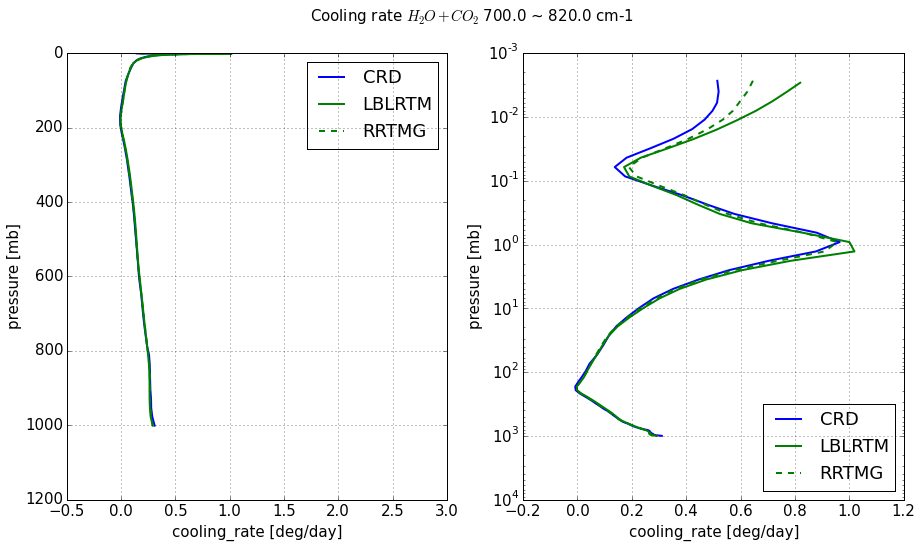

---------------------------------------------------------------------------


RRTMG Wavenumber band: 820.0 ~ 980.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -52.7555     0.0000  -52.7555      -0.00000
30   299.70000 -52.8217     0.0256  -52.7961      -0.00159
0   1013.00000 -53.9607     6.8658  -47.0949       0.20026

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -52.786179   0.000000 -52.786179      0.000000
30   299.800000 -52.844195   0.027763 -52.816432     -0.001085
0   1013.000000 -53.981634   6.720210 -47.261424      0.191545

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -52.763595   0.000000 -52.763595      0.000000
30   299.8000 -52.821095   0.026556 -52.794539     -0.001115
0   1013.0000 -53.960338   6.657655 -47.302682      0.181595

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.030679   0.000000  0.030679     -0.00000

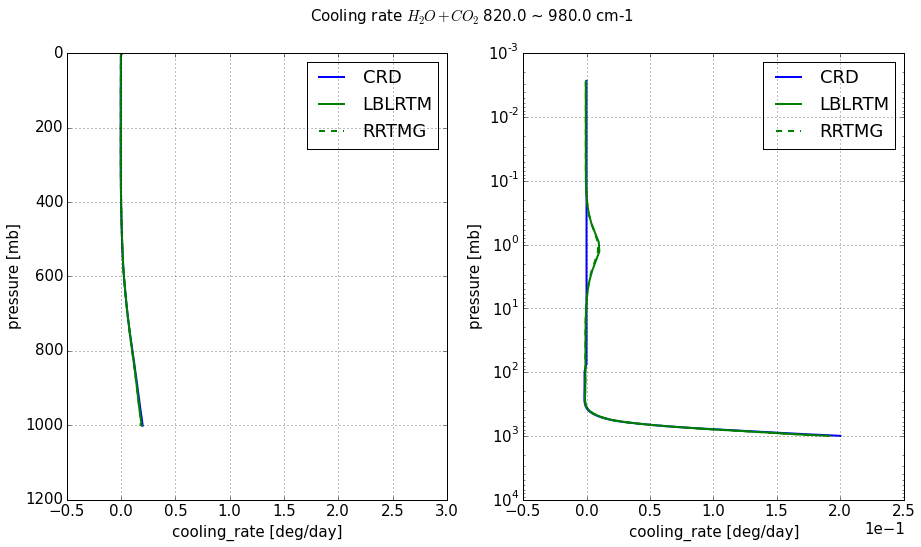

---------------------------------------------------------------------------


RRTMG Wavenumber band: 980.0 ~ 1080.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -25.9080     0.0000  -25.9080      -0.00000
30   299.70000 -26.0154     0.0354  -25.9800      -0.00216
0   1013.00000 -26.6402     2.9315  -23.7087       0.08206

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -25.953566   0.000000 -25.953566      0.000000
30   299.800000 -26.020186   0.026289 -25.993897     -0.001618
0   1013.000000 -26.654056   2.973756 -23.680300      0.085840

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -25.943237   0.000000 -25.943237      0.000000
30   299.8000 -26.009637   0.025266 -25.984371     -0.001620
0   1013.0000 -26.640246   2.937060 -23.703185      0.081212

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.045566   0.000000  0.045566     -0.0000

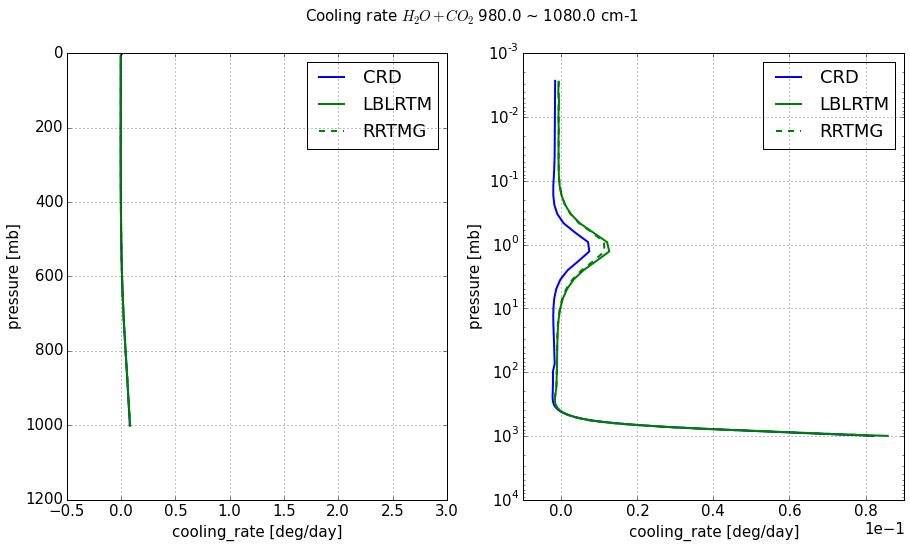

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1080.0 ~ 1180.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -20.4497     0.0000  -20.4497      -0.00000
30   299.70000 -20.4756     0.0114  -20.4642      -0.00058
0   1013.00000 -21.5225     4.7012  -16.8213       0.12514

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -20.484521   0.000000 -20.484521      0.000000
30   299.800000 -20.503118   0.011192 -20.491926     -0.000204
0   1013.000000 -21.535940   4.534923 -17.001017      0.118440

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -20.475800   0.000000 -20.475800      0.000000
30   299.8000 -20.494106   0.010743 -20.483362     -0.000221
0   1013.0000 -21.522739   4.515566 -17.007172      0.114826

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.034821   0.000000  0.034821     -0.000

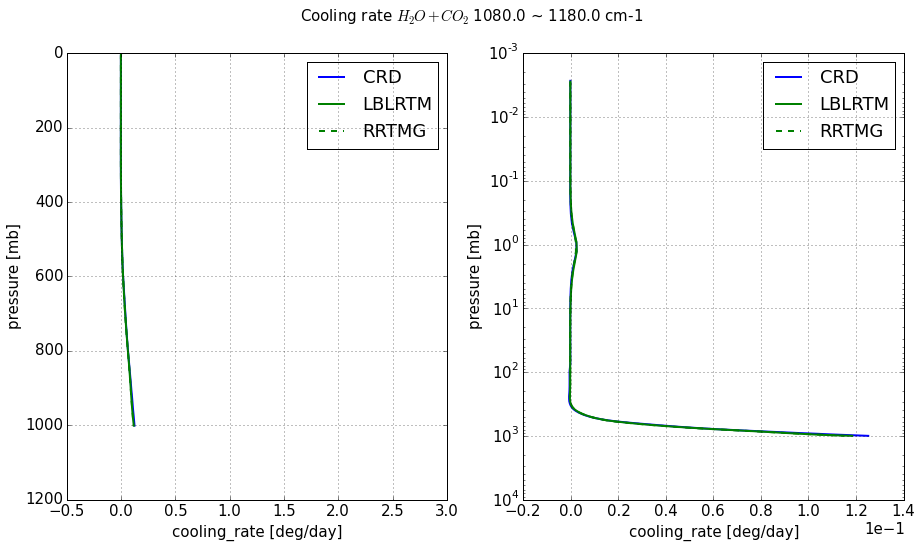

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1180.0 ~ 1390.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242 -22.0664     0.0000  -22.0664      -0.00000
30   299.70000 -22.3024     0.3088  -21.9936       0.01648
0   1013.00000 -31.2998    22.2084   -9.0914       0.25038

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -22.331858   0.000000 -22.331858      0.000000
30   299.800000 -22.502976   0.245861 -22.257115      0.013597
0   1013.000000 -31.323236  22.095176  -9.228060      0.246954

RRTMG
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -22.350054   0.000000 -22.350054      0.000000
30   299.8000 -22.522184   0.245395 -22.276789      0.012931
0   1013.0000 -31.299603  22.011875  -9.287728      0.247273

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.265458   0.000000  0.265458     -0.000

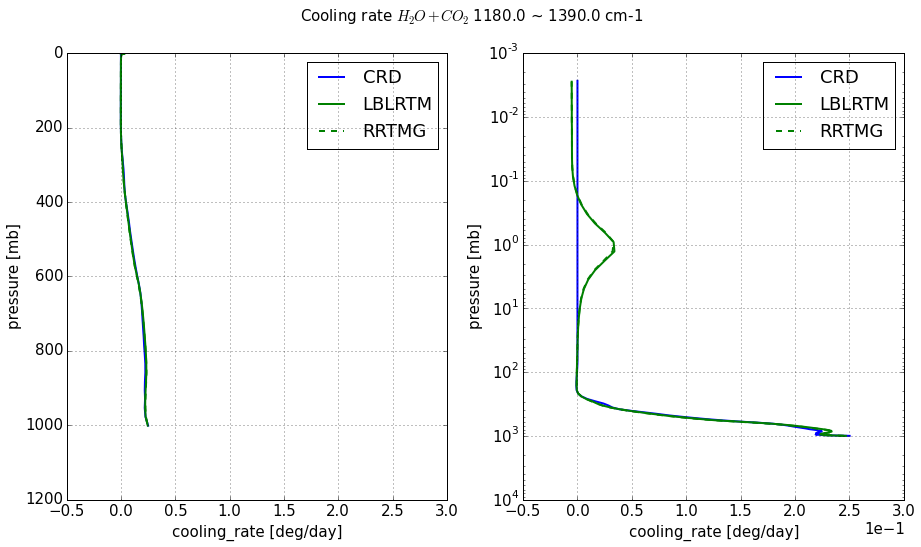

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1390.0 ~ 1480.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.4808     0.0000   -2.4808      -0.00000
30   299.70000  -2.7200     0.4662   -2.2538       0.02661
0   1013.00000  -8.8986     8.8866   -0.0120       0.00512

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -2.528982   0.000000 -2.528982      0.000000
30   299.800000 -2.762545   0.447686 -2.314859      0.027786
0   1013.000000 -8.906562   8.890356 -0.016206      0.005849

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -2.542891   0.000000 -2.542891      0.000000
30   299.8000 -2.778174   0.450207 -2.327967      0.026118
0   1013.0000 -8.898490   8.879338 -0.019151      0.004226

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.048182   0.000000  0.048182     -0.000000
30 -0.100000

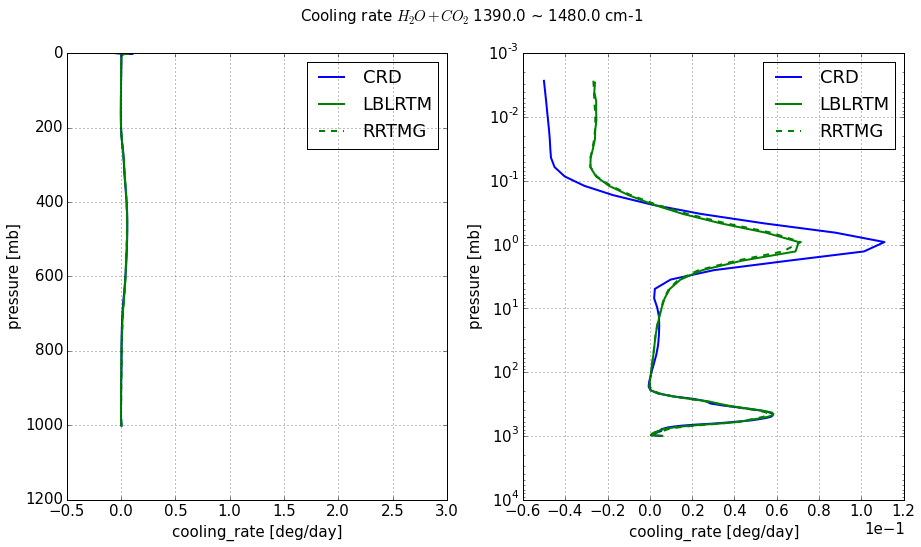

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1480.0 ~ 1800.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -3.2226     0.0000   -3.2226      -0.00000
30   299.70000  -3.8991     1.2651   -2.6340       0.06488
0   1013.00000 -17.8828    17.8685   -0.0143       0.00607

LBLRTM
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -3.353829   0.000000 -3.353829      0.000000
30   299.800000  -3.996974   1.237523 -2.759451      0.071399
0   1013.000000 -17.902258  17.865359 -0.036899      0.013083

RRTMG
     pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.0024  -3.362108   0.000000 -3.362108      0.000000
30   299.8000  -4.019579   1.248878 -2.770701      0.065686
0   1013.0000 -17.882889  17.851415 -0.031474      0.004635

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.131229   0.000000  0.131229     -0.000000
30 -

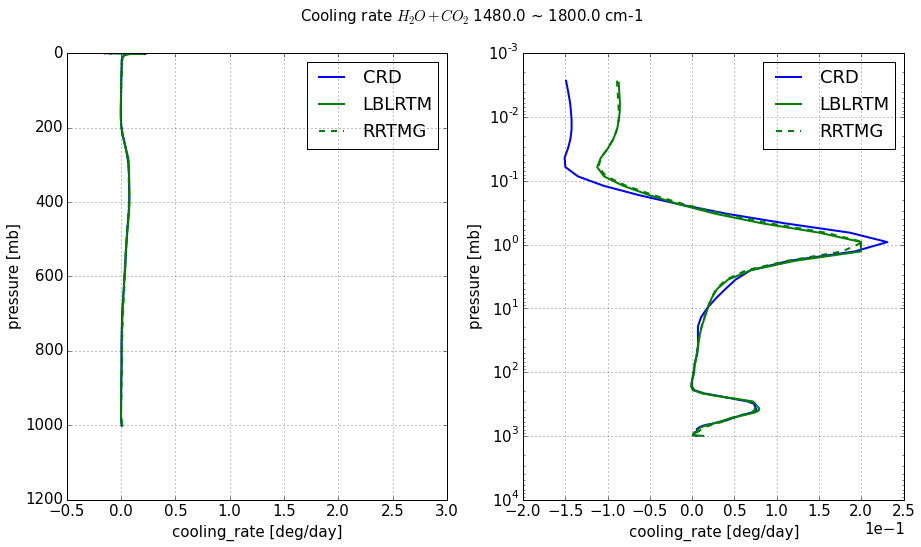

---------------------------------------------------------------------------


RRTMG Wavenumber band: 1800.0 ~ 2080.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -2.6369     0.0000   -2.6369      -0.00000
30   299.70000  -2.7157     0.0684   -2.6473      -0.00002
0   1013.00000  -5.9578     5.3168   -0.6410       0.04224

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -2.696757   0.000000 -2.696757      0.000000
30   299.800000 -2.775136   0.061014 -2.714122      0.000076
0   1013.000000 -5.965987   5.313618 -0.652369      0.038786

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -2.669900   0.000000 -2.669900      0.000000
30   299.8000 -2.748818   0.061618 -2.687199      0.000050
0   1013.0000 -5.957771   5.237331 -0.720440      0.018744

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.059857   0.000000  0.059857     -0.000000
30 -0.100000

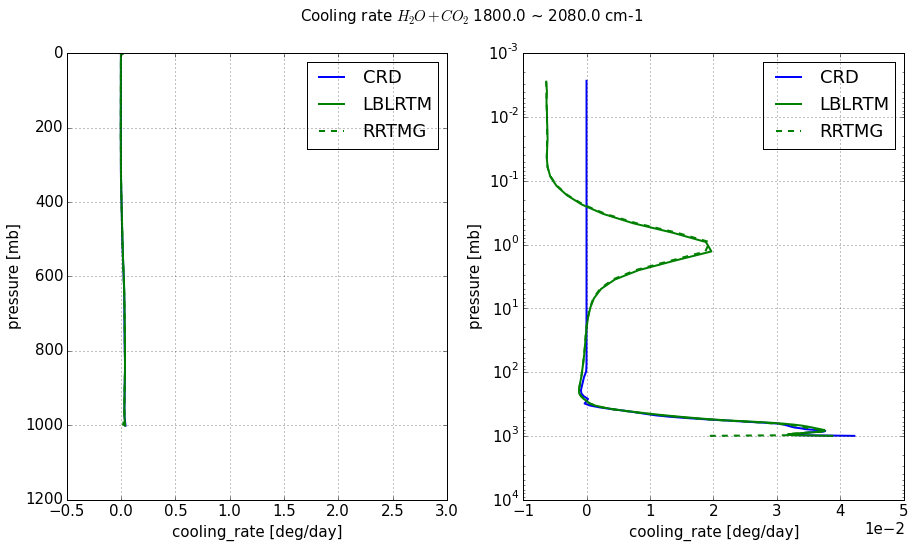

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2080.0 ~ 2250.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -1.1560     0.0000   -1.1560      -0.00000
30   299.70000  -1.2232     0.0116   -1.2116      -0.00238
0   1013.00000  -1.6390     0.6505   -0.9885       0.01436

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -1.436399   0.000000 -1.436399      0.000000
30   299.800000 -1.447322   0.001156 -1.446166     -0.000439
0   1013.000000 -1.641655   0.478265 -1.163390      0.013815

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -1.322278   0.000000 -1.322278      0.000000
30   299.8000 -1.343185   0.004052 -1.339133     -0.000832
0   1013.0000 -1.639014   0.600577 -1.038438      0.014676

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.280399   0.000000  0.280399     -0.000000
30 -0.100000

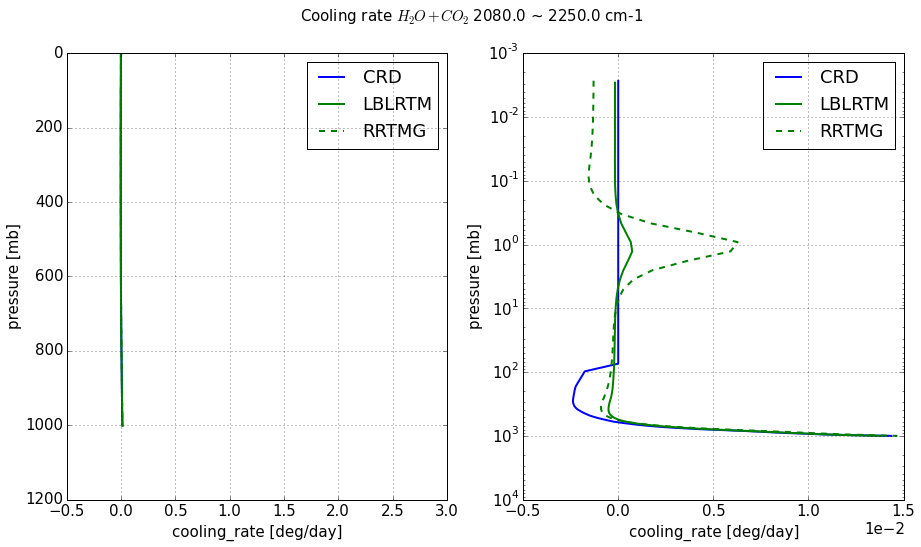

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2250.0 ~ 2380.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.0762     0.0000   -0.0762      -0.00000
30   299.70000  -0.0517     0.0513   -0.0004      -0.00001
0   1013.00000  -0.7316     0.7314   -0.0002       0.00008

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.228855   0.000000 -0.228855      0.000000
30   299.800000 -0.220079   0.034873 -0.185206     -0.000206
0   1013.000000 -0.732844   0.572768 -0.160076      0.002017

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.060052   0.000000 -0.060052      0.000000
30   299.8000 -0.061759   0.045020 -0.016739     -0.000337
0   1013.0000 -0.731556   0.724778 -0.006778      0.001245

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.152655   0.000000  0.152655     -0.000000
30 -0.100000

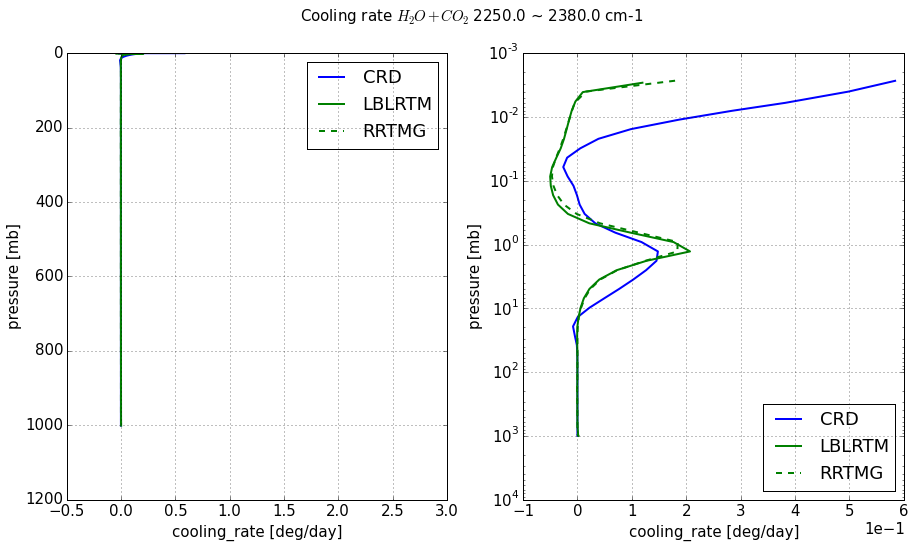

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2380.0 ~ 2600.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.4966     0.0000   -0.4966      -0.00000
30   299.70000  -0.5201     0.0037   -0.5164      -0.00107
0   1013.00000  -0.6658     0.1683   -0.4975       0.00318

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.595030   0.000000 -0.595030      0.000000
30   299.800000 -0.600106   0.002205 -0.597902     -0.000173
0   1013.000000 -0.667119   0.083955 -0.583164      0.001097

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.646175   0.000000 -0.646175      0.000000
30   299.8000 -0.642395   0.001199 -0.641196      0.000225
0   1013.0000 -0.665840   0.033077 -0.632763     -0.000042

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.098430   0.000000  0.098430     -0.000000
30 -0.100000

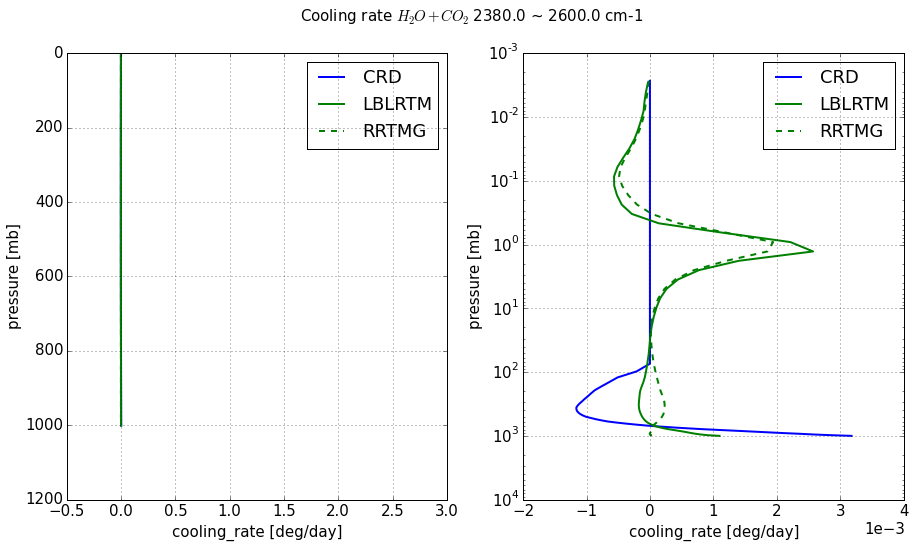

---------------------------------------------------------------------------


RRTMG Wavenumber band: 2600.0 ~ 3250.0 cm-1

CRD
      pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.00242  -0.3668     0.0000   -0.3668      -0.00000
30   299.70000  -0.3679     0.0002   -0.3677      -0.00013
0   1013.00000  -0.4713     0.1516   -0.3197       0.00297

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -0.367404   0.000000 -0.367404      0.000000
30   299.800000 -0.367797   0.000024 -0.367773     -0.000039
0   1013.000000 -0.404431   0.076238 -0.328193      0.002539

RRTMG
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -0.365735   0.000000 -0.365735      0.000000
30   299.8000 -0.366130   0.000023 -0.366107     -0.000038
0   1013.0000 -0.403547   0.075580 -0.327967      0.002114

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70  0.000003  0.000604   0.000000  0.000604     -0.000000
30 -0.100000

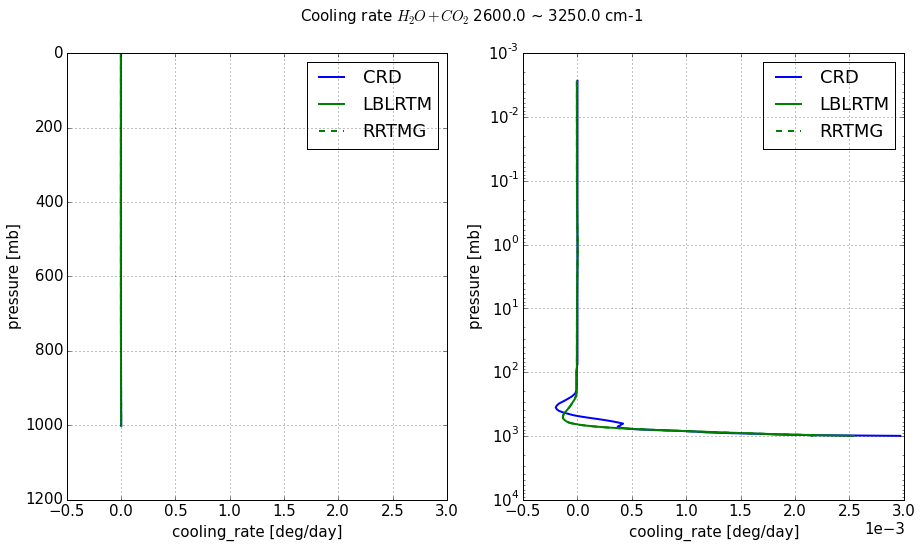

In [79]:
print('Flux tables and cooling rates in RRTMG spectral bands')
print()
print()

fluxtableNhrplot_by_rrtmg_bands(pnl_rrtmg, \
                                ('CRD', 'b', '-', pnl_crd), \
                               ('LBLRTM', 'g', '-', pnl_lblrtm))   

# In CLIRAD's wavenumber bands

In [80]:


def fluxtableNhrplot_by_clirad_bands(pnl_clirad, *infos_lbl):    
    global name_molecule, xlim_linear
    
    clirad_wbands = rtmtools.clirad.lw.info.wavenumber_bands()
    wbands = list(range(1, 10 + 1))
    wranges = {wband: clirad_wbands[wband] for wband in wbands}
    
    atm_levels = [70, 30, 0]
    
    names, colours, linestyles, pnls_lbl = map(list, zip(*infos_lbl))
        

    
    lbl_pnls_by_clirad_bands = [rtmtools.clirad.sw.analyse.lines2bands(pnl_lbl, wbands = wranges)\
                              for pnl_lbl in pnls_lbl]
    
    names.append('CLIRAD')
    colours.append('b')
    linestyles.append('--')
    pnls = [pnl_clirad] + lbl_pnls_by_clirad_bands
    
    for wband in wbands:
        print('---------------------------------------------------------------------------')
        print() 
        dfs = [pnl[wband].loc[atm_levels, :] for pnl in pnls]
        
        wlabel = ' '.join(['{} ~ {}'.format(*interval) for interval in wranges[wband]]) + ' cm-1'
        
        viz.tabulate_difference(dfs = dfs, 
                                names = names,
                                title = 'Wavenumber band: {}, {}'.format(wband, wlabel))
        
        dfs = [pnl[wband] for pnl in pnls]
        
        max_cr = max([df['cooling_rate'].max() for df in dfs])       

        viz.plot_pres_vs_hrcr(dfs = dfs,
                              names = names,
                              linestyles = linestyles, 
                              colours = colours,
                              title = 'Cooling rate {} {}'.format(name_molecule, wlabel),
                              cooling_rate = True,
                             xlim_linear = xlim_linear)
    
        display.display(plt.gcf()); plt.close()    


Flux tables and cooling rates in CLIRAD spectral bands


---------------------------------------------------------------------------


Wavenumber band: 1, 0 ~ 340 cm-1

CRD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -34.03330   0.001232 -34.032068      6.148719
30   299.800000 -36.40643  21.663380 -14.743050      1.350754
0   1013.000000 -51.09213  51.070570  -0.021560      0.007725

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -34.310935   0.000000 -34.310935      0.000000
30   299.800000 -36.441826  21.391389 -15.050437      1.376942
0   1013.000000 -51.093040  51.071508  -0.021532      0.007733

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -34.414211   0.000000 -34.414211      0.000000
30   299.8000 -36.581593  21.327243 -15.254350      1.271036
0   1013.0000 -51.100657  51.173323   0.072666      0.029632

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_

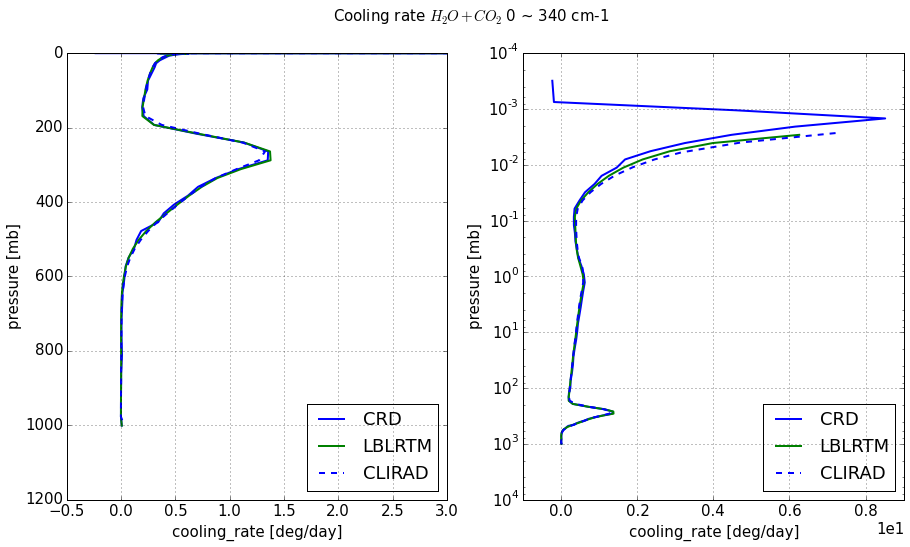

---------------------------------------------------------------------------


Wavenumber band: 2, 340 ~ 540 cm-1

CRD
       pressure   flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -59.82235   0.000003 -59.822347     -0.097136
30   299.800000 -60.99290   6.915163 -54.077737      0.649110
0   1013.000000 -82.31579  81.543440  -0.772350      0.156217

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.528548   0.000000 -60.528548      0.000000
30   299.800000 -61.592658   6.658546 -54.934111      0.644337
0   1013.000000 -82.315835  81.336060  -0.979775      0.130558

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.315923   0.000000 -60.315923      0.000000
30   299.8000 -61.416337   6.875528 -54.540809      0.627878
0   1013.0000 -82.315849  81.379649  -0.936199      0.138696

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0  0.706198   0.000003  0.706201     -0

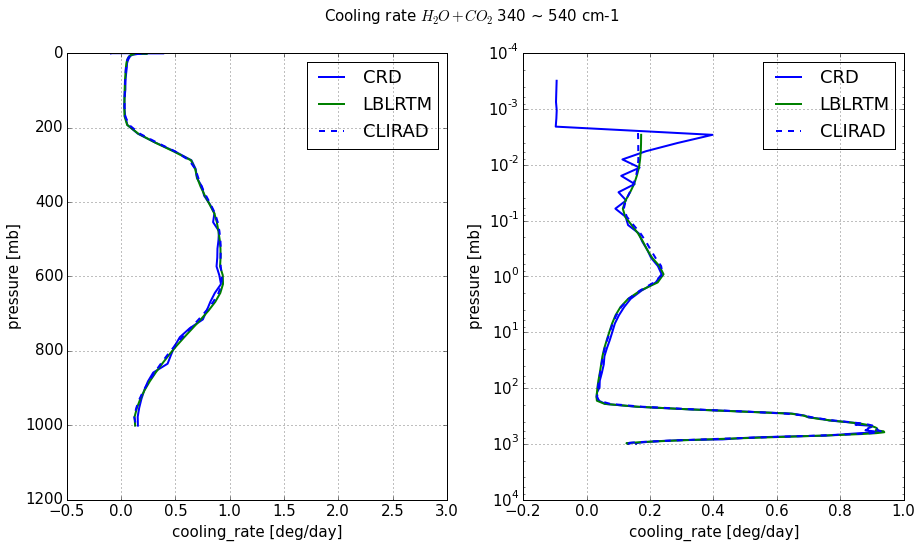

---------------------------------------------------------------------------


Wavenumber band: 3, 540 ~ 800 cm-1

CRD
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -68.96323   0.012381 -68.950849     19.811190
30   299.800000  -74.97459  21.326890 -53.647700      0.216908
0   1013.000000 -112.81600  98.637690 -14.178310      0.521221

LBLRTM
       pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.002417  -68.646451   0.000000 -68.646451      0.000000
30   299.800000  -74.846726  21.737563 -53.109162      0.234086
0   1013.000000 -112.837813  98.763525 -14.074288      0.429695

CLIRAD
     pressure     flux_up  flux_down   net_flux  cooling_rate
70     0.0024  -68.706526   0.000000 -68.706526      0.000000
30   299.8000  -75.092107  21.565922 -53.526185      0.224961
0   1013.0000 -112.816764  98.440653 -14.376111      0.433820

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.316779   0.012381 -0.3

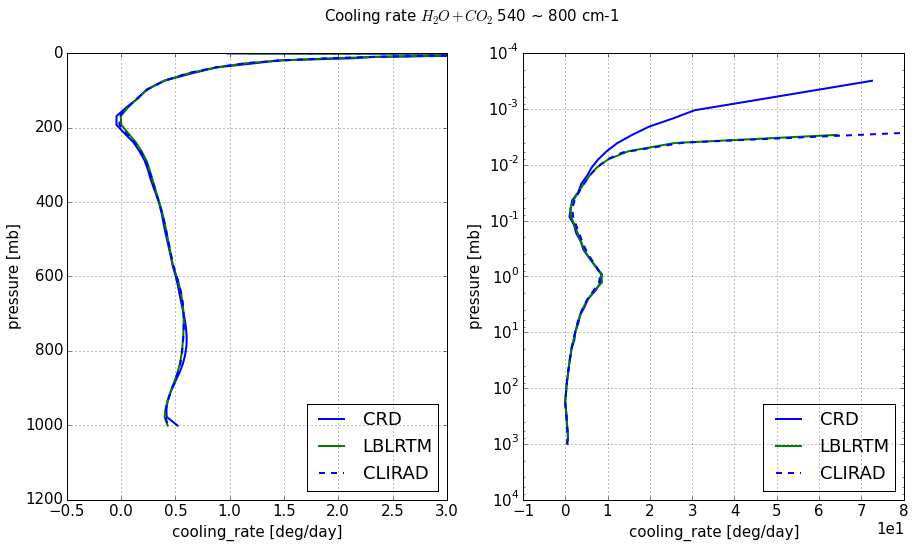

---------------------------------------------------------------------------


Wavenumber band: 4, 800 ~ 980 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -59.98326  4.420017e-08 -59.983260     -0.000433
30   299.800000 -60.03240  2.851227e-02 -60.003888     -0.001018
0   1013.000000 -61.64931  9.531820e+00 -52.117490      0.258610

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -60.138326   0.000000 -60.138326      0.000000
30   299.800000 -60.216994   0.040386 -60.176607     -0.001240
0   1013.000000 -61.681243   8.624879 -53.056364      0.237852

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -60.121864   0.000000 -60.121864      0.000000
30   299.8000 -60.198463   0.037885 -60.160579     -0.001276
0   1013.0000 -61.657526   8.524920 -53.132606      0.225768

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0  0.155066  4.420017e-0

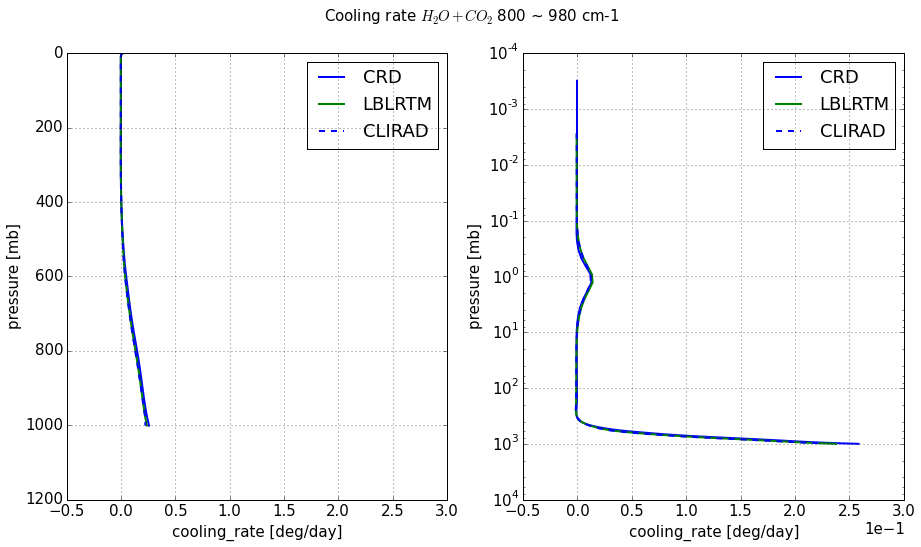

---------------------------------------------------------------------------


Wavenumber band: 5, 980 ~ 1100 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -30.44897  4.965726e-07 -30.448970     -0.000884
30   299.800000 -30.51914  2.932311e-02 -30.489817     -0.001695
0   1013.000000 -31.34389  3.985245e+00 -27.358645      0.112096

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -30.504253   0.000000 -30.504253      0.000000
30   299.800000 -30.582386   0.030529 -30.551857     -0.001934
0   1013.000000 -31.354231   3.583960 -27.770271      0.102604

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -30.491855   0.000000 -30.491855      0.000000
30   299.8000 -30.569473   0.029239 -30.540235     -0.001928
0   1013.0000 -31.337711   3.550774 -27.786937      0.097630

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0  0.055283  4.965726e-

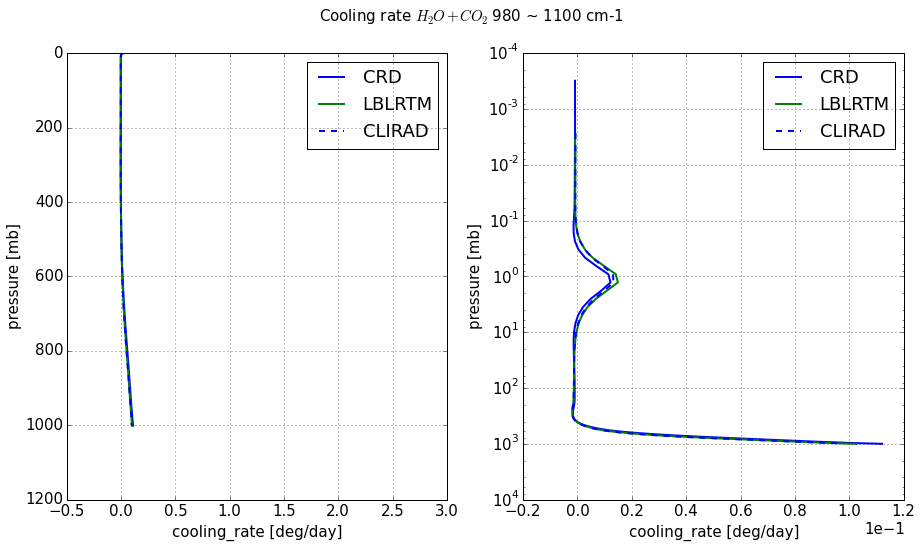

---------------------------------------------------------------------------


Wavenumber band: 6, 1100 ~ 1215 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -21.79535  2.657388e-13 -21.795350 -3.024772e-09
30   299.800000 -21.80484  8.713370e-03 -21.796127  9.956238e-05
0   1013.000000 -23.27341  6.326471e+00 -16.946939  1.579750e-01

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -21.772813   0.000000 -21.772813      0.000000
30   299.800000 -21.785274   0.012782 -21.772491      0.000305
0   1013.000000 -23.269652   6.306189 -16.963463      0.160483

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -21.757502   0.000000 -21.757502      0.000000
30   299.8000 -21.770095   0.012590 -21.757505      0.000265
0   1013.0000 -23.254791   6.299774 -16.955017      0.156423

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.022537  2.657388e

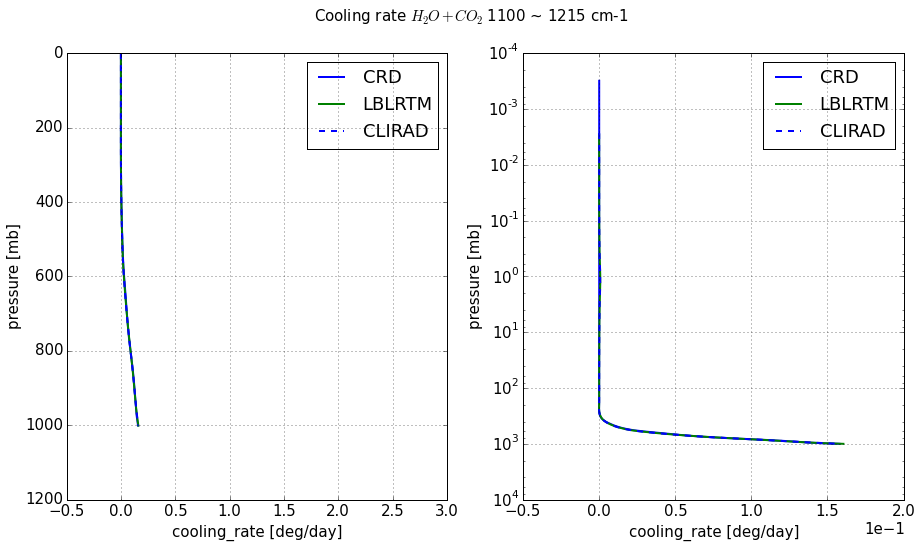

---------------------------------------------------------------------------


Wavenumber band: 7, 1215 ~ 1380 cm-1

CRD
       pressure   flux_up     flux_down   net_flux  cooling_rate
70     0.002417 -16.32561  4.906120e-10 -16.325610 -6.565916e-07
30   299.800000 -16.46534  2.195141e-01 -16.245826  1.407870e-02
0   1013.000000 -23.74060  1.784015e+01  -5.900450  2.084762e-01

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -16.035589   0.000000 -16.035589      0.000000
30   299.800000 -16.184856   0.212737 -15.972118      0.011741
0   1013.000000 -23.755165  18.582951  -5.172214      0.186966

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -16.054611   0.000000 -16.054611      0.000000
30   299.8000 -16.205150   0.213088 -15.992062      0.011235
0   1013.0000 -23.736876  18.486857  -5.250019      0.187462

CRD - LBLRTM
    pressure   flux_up     flux_down  net_flux  cooling_rate
70         0 -0.290021  4.906120e

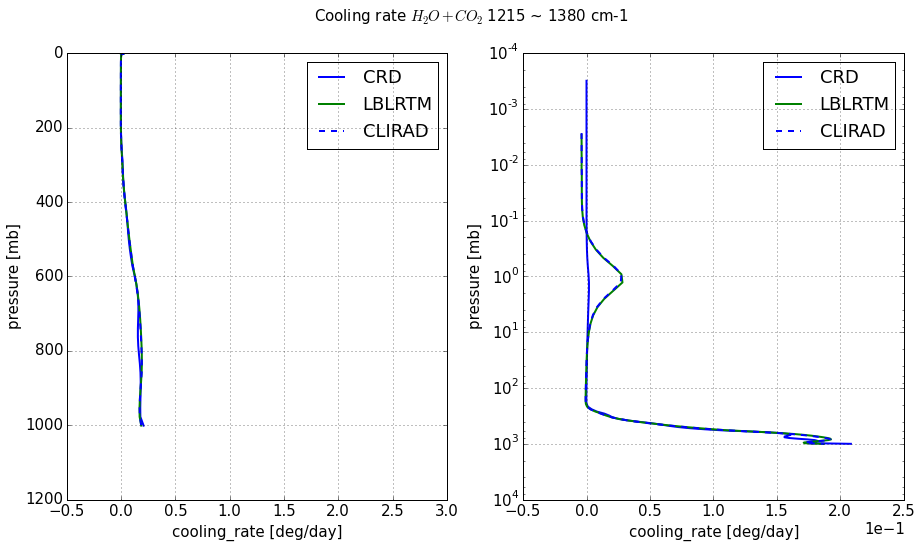

---------------------------------------------------------------------------


Wavenumber band: 8, 1380 ~ 1900 cm-1

CRD
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -7.341434   0.000002 -7.341432     -0.165602
30   299.800000  -8.295568   1.769966 -6.525602      0.097178
0   1013.000000 -30.880560  30.708790 -0.171770      0.059902

LBLRTM
       pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.002417  -7.262541   0.000000 -7.262541      0.000000
30   299.800000  -8.190465   1.754848 -6.435618      0.102030
0   1013.000000 -30.729595  30.641071 -0.088524      0.027165

CLIRAD
     pressure    flux_up  flux_down  net_flux  cooling_rate
70     0.0024  -7.301402   0.000000 -7.301402      0.000000
30   299.8000  -8.245419   1.768596 -6.476823      0.094446
0   1013.0000 -30.697533  30.597038 -0.100495      0.019151

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.078893   0.000002 -0.078891     -0.16560

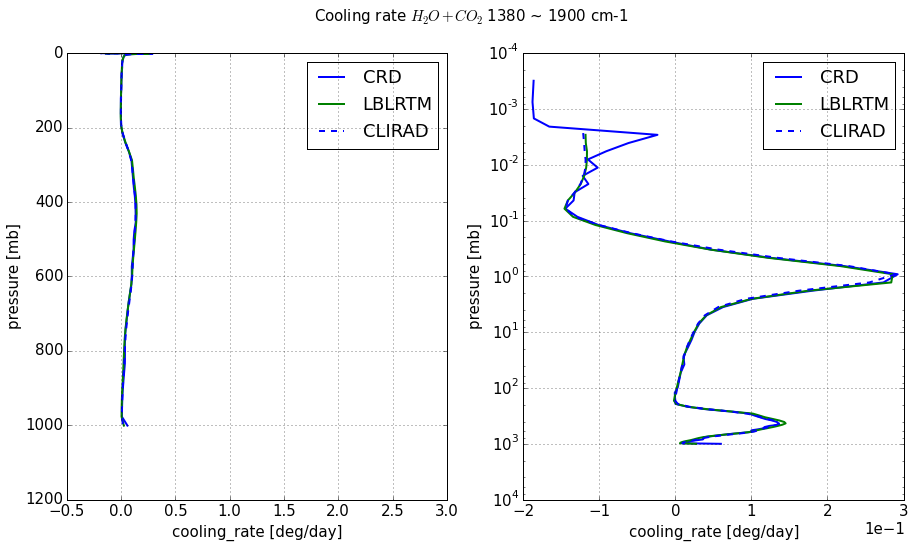

---------------------------------------------------------------------------


Wavenumber band: 9, 1900 ~ 3000 cm-1

CRD
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -4.861082   0.000000 -4.861082     -0.000000
30   299.800000 -4.875098   0.012047 -4.863051     -0.000178
0   1013.000000 -6.674498   3.427002 -3.247496      0.060868

LBLRTM
       pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.002417 -4.402004   0.000000 -4.402004      0.000000
30   299.800000 -4.453260   0.056926 -4.396334     -0.001962
0   1013.000000 -6.625445   3.770242 -2.855203      0.051202

CLIRAD
     pressure   flux_up  flux_down  net_flux  cooling_rate
70     0.0024 -4.132859   0.000000 -4.132859      0.000000
30   299.8000 -4.195829   0.068889 -4.126940     -0.002055
0   1013.0000 -6.614782   3.932153 -2.682629      0.028244

CRD - LBLRTM
    pressure   flux_up  flux_down  net_flux  cooling_rate
70         0 -0.459078   0.000000 -0.459078     -0.000000
30        

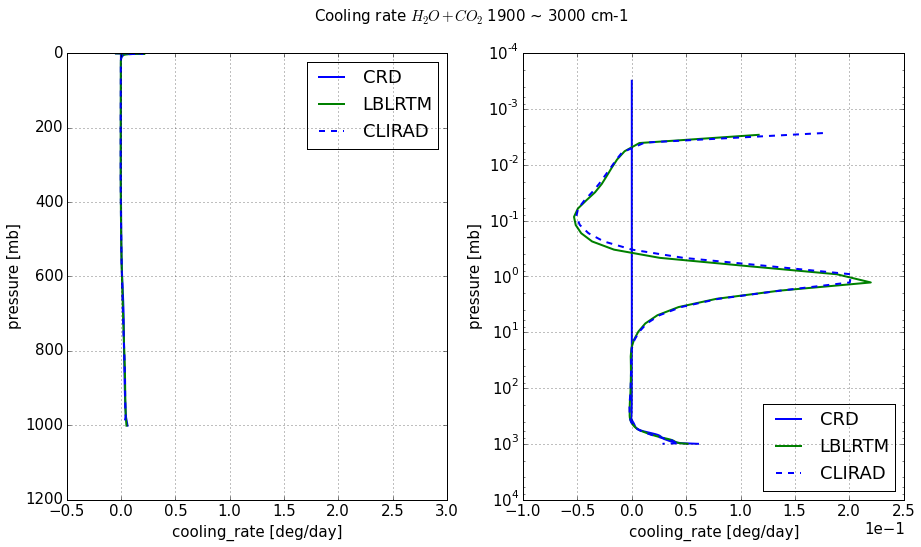

---------------------------------------------------------------------------


Wavenumber band: 10, 540 ~ 620 cm-1

CRD
       pressure  flux_up  flux_down  net_flux  cooling_rate
70     0.002417       -0          0         0            -0
30   299.800000       -0          0         0            -0
0   1013.000000       -0          0         0            -0

LBLRTM
       pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.002417 -25.557881   0.000000 -25.557881      0.000000
30   299.800000 -26.837053   3.061298 -23.775755      0.103920
0   1013.000000 -36.235420  34.534637  -1.700784      0.164543

CLIRAD
     pressure    flux_up  flux_down   net_flux  cooling_rate
70     0.0024 -25.541536   0.000000 -25.541536      0.000000
30   299.8000 -26.832667   3.040885 -23.791781      0.101662
0   1013.0000 -36.231410  34.549568  -1.681842      0.163333

CRD - LBLRTM
    pressure    flux_up  flux_down   net_flux  cooling_rate
70         0  25.557881   0.000000  25.557881     -0.00

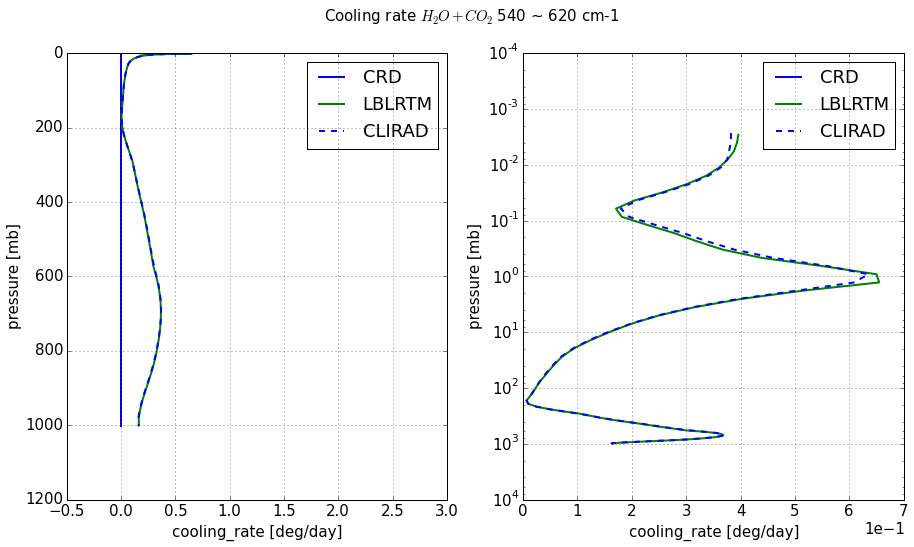

In [81]:
print('Flux tables and cooling rates in CLIRAD spectral bands')
print()
print()

fluxtableNhrplot_by_clirad_bands(pnl_clirad, \
                                ('CRD', 'b', '-', pnl_crd), \
                                ('LBLRTM', 'g', '-', pnl_lblrtm))

In [73]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')